# Advanced Data Analytics for Management Support - Final Assignment (Summer 2020)

## Table of Contents

    1. Introduction
    2. Data Loading and Cleaning
    3. Feature Recovery
    4. Feature Analysis and Engineering
        4.1 Target Distribution
        4.2 Reading Ease
        4.3 Date features
        4.4 Title Length
        4.5 Author
        4.6 Most Used Words
    5. Model Selection
        5.1 Data Preparation
        5.2 Benchmark Models
            5.2.1 Linear Regression
            5.2.2 Random Forest
            5.2.3 XGBoost
            5.2.4 Basic GRU
        5.3 RNN Architecture
            5.3.1 LSTM
            5.3.2 Bidirectional LSTM
            5.3.3 Deep LSTM
        5.4 Full Model Architecture
    6. Application to Test Set
    7. Conclusion


## 1. Introduction

The task of this assignment is to predict the total number of claps a medium.com article will receive based on different webscraped features like the text, number of responses, and date of creation. The main focus hereby lies on using NLP techniques to harness any predictive power that may lie within the text.

In the following, we analyze the train and test data, recover and alter some of the features, as well as create new ones. Afterwards, different modeling approaches are considered and an NLP pipeline is chosen. Finally, the model is applied to our test data.

**Note on reproducibility**

Since the models are all trained using a GPU, and CPU training was infeasible time-wise, it is unfortunately not possible to ensure exact reproducibility in these cases. Everywhere reproducible randomness was possible, it was ensured.

In [56]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import re
import datetime
import time
import textstat
from bs4 import BeautifulSoup
from collections import Counter
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, concatenate, Dense, Embedding, LSTM, GRU, Bidirectional, BatchNormalization, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from tensorflow.keras import activations, losses
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from utils import get_embedding_matrix

---

## 2. Data Loading and Cleaning  <a name="introduction"></a>

In [419]:
train = pd.read_csv("Data/train.csv", sep=",", encoding="utf-8")
test = pd.read_csv("Data/test.csv", sep=",", encoding="utf-8", index_col="index")

Inspecting the columns of both the train and the test set, we notice a large discrepancy between them. 

In [699]:
train.columns

Index(['audioVersionDurationSec', 'codeBlock', 'codeBlockCount',
       'collectionId', 'createdDate', 'createdDatetime', 'firstPublishedDate',
       'firstPublishedDatetime', 'imageCount', 'isSubscriptionLocked',
       'language', 'latestPublishedDate', 'latestPublishedDatetime',
       'linksCount', 'postId', 'readingTime', 'recommends',
       'responsesCreatedCount', 'socialRecommendsCount', 'subTitle',
       'tagsCount', 'text', 'title', 'totalClapCount', 'uniqueSlug',
       'updatedDate', 'updatedDatetime', 'url', 'vote', 'wordCount',
       'publicationdescription', 'publicationdomain',
       'publicationfacebookPageName', 'publicationfollowerCount',
       'publicationname', 'publicationpublicEmail', 'publicationslug',
       'publicationtags', 'publicationtwitterUsername', 'tag_name', 'slug',
       'name', 'postCount', 'author', 'bio', 'userId', 'userName',
       'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'],
      dtype='object')

In [697]:
test.columns

Index(['Unnamed: 0', 'Author', 'PublicationDetails', 'Responses', 'Header',
       'Text', 'Length'],
      dtype='object')

First, we rename some of the columns which obviously belong together but are named differently. Also, we can drop the "Unnamed: 0" column of the test set.

In [420]:
test.rename(columns={'Author': 'author', 'Header': 'title', 'Text': 'text'}, inplace=True)
train.rename(columns={'responsesCreatedCount': 'Responses'}, inplace=True)
test.drop(columns="Unnamed: 0", inplace=True)

Looking at the "language" feature of the train set, we observe that about 7.8% of our data consist of non-english articles, which don't hold much value for us. Since our focus in this work lies on Natural Language Processing, we will limit ourselves to the English language only. Everything else would overproportionally increase the required effort relative to the number of dropped articles.

In [702]:
len(train[train['language'] != "en"]) / len(train)

0.07841131423543425

We therefore remove non-english texts and drop the column.

In [421]:
# Remove non-english posts:
train = train[train['language'] == "en"]
train.drop(columns="language", inplace=True)

Going further, we notice that a large share of rows have duplicate post IDs, which is likely a result of the webscraping. We investigate the reason for this by example of the first post in the data:

In [705]:
train[train.postId == train.postId[0]]

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,...,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104


We filter the columns that are actually different (NaNs seem to behave weirdly here):

In [713]:
train.loc[:2,train.loc[0,:] != train.loc[1,:]]

,codeBlock,publicationdomain,publicationfollowerCount,tag_name,slug,name,postCount,bio
0,NaN,NaN,NaN,Blockchain,blockchain,Blockchain,265164.0,NaN
1,NaN,NaN,NaN,Samsung,samsung,Samsung,5708.0,NaN
2,NaN,NaN,NaN,It,it,It,3720.0,NaN


The reason for the duplicate articles seems to be that there is one row per article and tag. Since there is no tag feature in the test data, the only reason for keeping the tags would be the creation of some kind of tag prediction model.

The following code block shows that are around 17000 unique tags. The most used tags are all closely related to each other. We therefore deem a tag prediction model infeasible and proceed to drop post ID duplicates. 

In [723]:
train.tag_name.value_counts().sort_values(ascending=False) / len(train)

Artificial Intelligence     0.127395
Machine Learning            0.106278
Data Science                0.064773
Deep Learning               0.024040
Technology                  0.023920
                              ...   
Biracial                    0.000004
Opencog                     0.000004
Future Of Data Analytics    0.000004
Jamb                        0.000004
Myntra                      0.000004
Name: tag_name, Length: 17049, dtype: float64

In [423]:
train.drop_duplicates(subset=["postId"], inplace=True)
print(f"This leaves uf with {len(train)} rows.")

This leaves uf with 66380 rows.


Since the webscraping seems to have been transformed to tabular form with slight redundancy, we check whether we actually eliminated all the text duplicates:

In [727]:
for row in train.text:
    occurences = train.index[np.where(train.text == row)[0]]
    if len(occurences) > 1:
        print(f"Duplicate texts found in rows {occurences.tolist()}")
        break

Duplicate texts found in rows [726, 24773, 222395]


It appears we are still dealing with duplicate texts. We check the reason for this:

In [730]:
train.loc[occurences, train.loc[occurences[0],:] != train.loc[occurences[1],:]]

,codeBlock,collectionId,createdDate,createdDatetime,latestPublishedDate,latestPublishedDatetime,postId,tagsCount,totalClapCount,uniqueSlug,...,url,publicationdescription,publicationdomain,publicationfacebookPageName,publicationfollowerCount,publicationname,publicationpublicEmail,publicationslug,publicationtags,publicationtwitterUsername
726,NaN,NaN,2017-09-21,2017-09-21 04:49:58,2017-09-21,2017-09-21 11:46:03,10c22f3e1231,1,4,whos-afraid-of-the-big-bad-ai-10c22f3e1231,...,https://medium.com/s/story/whos-afraid-of-the-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24773,NaN,NaN,2017-09-26,2017-09-26 22:15:45,2017-09-26,2017-09-26 22:16:34,2a80f37f7a4c,5,17,whos-afraid-of-the-big-bad-ai-2a80f37f7a4c,...,https://medium.com/s/story/whos-afraid-of-the-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222395,NaN,66a6d870e14e,2017-09-21,2017-09-21 04:51:15,2017-09-21,2017-09-21 04:55:18,fa5aefce7328,5,0,whos-afraid-of-the-big-bad-ai-fa5aefce7328,...,https://medium.com/s/story/whos-afraid-of-the-...,"Thoughts, guides and other shenanigans from th...",NaN,athennianhq,NaN,Athennian Engineering + Data Science,hello@athennian.com,athenian-engineering,"LEGALTECH,DEVOPS,ENGINEERING,CULTURE,TEAMWORK",athennian


This time, it is not as clear. It seems to boil down to downright reposted articles with the exact same content. If we check the URLs of the different articles, we do find this to be the case.

In [732]:
print(train.loc[occurences[0], "url"])
print(train.loc[occurences[1], "url"])
print(train.loc[occurences[2], "url"])

https://medium.com/s/story/whos-afraid-of-the-big-bad-ai-10c22f3e1231
https://medium.com/s/story/whos-afraid-of-the-big-bad-ai-2a80f37f7a4c
https://medium.com/s/story/whos-afraid-of-the-big-bad-ai-fa5aefce7328


The articles even have differing clap counts.

We assume that people will not read and clap for the same article twice, so we eliminate these duplicates and simply sum the clap counts.

In [ ]:
to_drop = []
for row in train.index:
    if row in to_drop:
        continue
    duplicate_rows = train.index[np.where(train.text == train.text[row])[0]]
    if len(duplicate_rows) > 1:
        train.loc[row, "totalClapCount"] = np.sum(train.loc[duplicate_rows, "totalClapCount"])
        to_drop += duplicate_rows[1:].tolist()

train.drop(to_drop, inplace=True)

In [ ]:
with open('train_nodupl.pkl', 'wb') as file_name:
    pickle.dump(train, file_name)

We're now ready to perform text cleaning. To save time, this is done in parallel on multiple CPU cores (see **mp_cleaning.py**). Multiprocessing does not work in a Jupyter notebook, since it cannot be done in interactive mode, but has to be fully run.

The following steps are performed:

1. Newline indicators are removed ("\n" and "\xa0")
2. html content is removed
3. URLs are removed
4. Bibliographies are removed (they consist mainly of names and other information our model cannot process)
5. Non-alphabetic characters are removed
6. English contractions are expanded (they sometimes proved problematic for the stopword filter)
7. Stopwords are filtered out
8. The words are lemmatized

The cleaned text and title features for both data sets are loaded in the following:

In [426]:
with open('test_text_clean.pkl', 'rb') as file_name:
    test["text_clean"] = pickle.load(file_name)

with open('test_titles_clean.pkl', 'rb') as file_name:
    test["title_clean"] = pickle.load(file_name)

with open('train_text_clean.pkl', 'rb') as file_name:
    train["text_clean"] = pickle.load(file_name)
    
with open('train_titles_clean.pkl', 'rb') as file_name:
    train["title_clean"] = pickle.load(file_name)

Unfortunately, the cleaning loop creates some word artifacts, which we have to further treat.

First, we reduce overly repeating letters. In the English language, there never appear more than 2 units of the same letter in sequence. We can therefore delete letters that violate this rule, using the following function courtesy of https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html

In [427]:
def reduce_lengthening(text):
    # https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [428]:
train["text_clean"] = train.text_clean.apply(reduce_lengthening)
train["title_clean"] = train.title_clean.apply(reduce_lengthening)

In [429]:
test["text_clean"] = test.text_clean.apply(reduce_lengthening)
test["title_clean"] = test.title_clean.apply(reduce_lengthening)

Second, we remove short and/or unnecessary words. Words with length 1 are entirely removed, while words with length 2 are only kept if they match with a custom list that we defined by having examined the 2-letter out-of-vocabulary words of our pre-trained embeddings which we introduce later.

Third, repeating spaces as well as spaces at the start/end of a text are removed.

In [430]:
def short_words(text):
    for word in text.split():
        if len(word) == 1:
            text = re.sub(r"\b"+word+r"\b", "", text)
        elif len(word) < 3:
            if not word in ["tf","py", "rl", "ad", "do","id","ip","nn","at","pi","tv","ai", "ui", "io", "us", "ml", "go", "vr","co","ex","hr","uk","en","iq","ki", "oh", "eu","vm","mr","ar","fb","np","ok","bi","dr"]:
                text = re.sub(r"\b"+word+r"\b", "", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"^\s|\s$", "", text)
    return text

In [431]:
train["title_clean"] = train.title_clean.apply(short_words)
train["text_clean"] = train.text_clean.apply(short_words)

In [432]:
test["title_clean"] = test.title_clean.apply(short_words)
test["text_clean"] = test.text_clean.apply(short_words)

* * *

Now that our text features are clean, we can pay attention to non-text features and transform them into a useable state.

We start by cleaning the "Responses" feature of the test set, which we would like to convert to numbers:

In [433]:
test.Responses

index
0      627 responses
1      156 responses
2      176 responses
5       72 responses
7       19 responses
           ...      
598    181 responses
599     24 responses
600     24 responses
601    116 responses
602     34 responses
Name: Responses, Length: 514, dtype: object

We remove all non-numeric characters and fill in the 82 missing values with the median.

In [763]:
for t in test.index:
    test.loc[t, "Responses"] = re.sub(r"[^0-9]", "", str(test.Responses[t]))
    if test.loc[t, "Responses"] == "":
        test.loc[t, "Responses"] = np.nan
test.Responses = test.Responses.astype("float32")

In [764]:
sum(test.Responses.isnull())

82

In [765]:
test.Responses.fillna(test.Responses.median(), inplace=True)

Moving on, the date columns of both data sets are not useable in their current state.

In [771]:
train.createdDate

0         2018-09-18
3         2018-01-07
7         2018-03-08
11        2018-04-16
16        2017-10-20
             ...    
279552    2018-01-04
279557    2018-05-07
279567    2018-06-12
279570    2017-11-27
279572    2018-03-21
Name: createdDate, Length: 66089, dtype: object

In [772]:
test.PublicationDetails

index
0         Daniel Jeffries in HackerNoon.comJul 31, 2017
1            Noam Levenson in HackerNoon.comDec 6, 2017
2         Daniel Jeffries in HackerNoon.comJul 21, 2017
5          Haseeb Qureshi in HackerNoon.comFeb 19, 2018
7            William Belk in HackerNoon.comJan 28, 2018
                             ...                       
598    Tim Romero in Startup Lessons LearnedJun 9, 2016
599                            Product HuntJun 10, 2016
600                                  Joe ProcopioMar 19
601                 Winerist in Be YourselfMar 18, 2016
602             Aytekin Tank in The StartupJan 11, 2018
Name: PublicationDetails, Length: 514, dtype: object

We start by cleaning the test set. From the raw PublicationDetails column, we extract the weekday, month, and year of publication.

In [886]:
# Make PublicationDetails column of test set into date:
weekdays = pd.Series(index=test.index,dtype="str")
months = pd.Series(index=test.index,dtype="str")
years = pd.Series(index=test.index,dtype="str")

In [887]:
for ix in test.index:
    rawdate = ''.join(re.findall(r"(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)( \d+)(, \d{4})?", test.PublicationDetails[ix])[0])
    if "," in rawdate:  # If a year number is present
        dt = datetime.datetime.strptime(rawdate, '%b %d, %Y')
        weekdays[ix] = dt.strftime('%A')
        months[ix] = dt.strftime('%B')
        years[ix] = dt.strftime('%Y')
    else:
        dt = datetime.datetime.strptime(rawdate, '%b %d')
        weekdays[ix] = np.nan
        months[ix] = dt.strftime('%B')
        years[ix] = np.nan

In [ ]:
test["year"] = years.fillna("None").astype("category")
test["month"] = months.astype("category")
test["weekday"] = weekdays.fillna("None").astype("category")

Unfortunately, there appear to be some missing years, which results in missing weekdays, too. We try to resolve this by looking for a year in the text:

In [505]:
for ix in test.loc[test.year=="None"].index:
    print(re.findall(r"\b201[0-9]\b", test.text[ix]))

['2018', '2018']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['2019']
['2019', '2019']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['2019', '2016', '2019', '2019']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['2019']
['2019']
[]
[]
[]
[]
[]
[]
['2015', '2017', '2015', '2015', '2015', '2017', '2015', '2017', '2018']
[]
[]
[]
[]
['2015', '2018']
['2018', '2018', '2017', '2017', '2016', '2015', '2015', '2014', '2014']
[]
[]
[]
[]
[]
[]
['2015', '2017', '2015', '2015', '2015', '2017', '2015', '2017', '2018']
[]
[]
['2015', '2018']
['2018', '2018', '2017', '2017', '2016', '2015', '2015', '2014', '2014']
[]
['2018', '2018']
['2014', '2018']
[]
[]
[]
[]


We unfortunately find no evidence of a joint pattern, and leave the years and weekdays as "None"-category.

The train set is a little easier to clean since there are no missing values:

In [776]:
weekdays = pd.Series(index=train.index,dtype="str")
months = pd.Series(index=train.index,dtype="str")
years = pd.Series(index=train.index,dtype="str")

In [777]:
dt = train.createdDate.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
weekdays = dt.apply(lambda x: x.strftime('%A'))
months = dt.apply(lambda x: x.strftime('%B'))
years = dt.apply(lambda x: x.strftime('%Y'))

In [ ]:
train["year"] = years.astype("category")
train["month"] = months.astype("category")
train["weekday"] = weekdays.astype("category")
train["weekday"].cat.add_categories("None", inplace=True)

---

## 3. Feature Recovery

We already saw that the test set contains vastly less features than the train set. Some of the features can be recovered, however. In the following, we recover the imageCount, wordCount, readingTime, and Length features in the test set.

First, we figure out that the "Length" feature of the test set is simply the character count of the unclean text feature:

In [490]:
all(test.Length == [len(x) for x in test.text])

True

However: The text in the test set is different than the one in the train set. We want to preserve this feature but the values should be calculated on equal footing.

We therefore have to half-clean the text (not removing punctuation, stop words etc.) to make sure that both datasets are of equal format. Afterwards, we can perform the recovery operations.

Furthermore, the half clean versions of the texts will be useful in feature engineering later-on.

The half_clean function is basically the same as our full cleaning function, except that it allows punctuation and numbers, and does not remove stopwords or perform lemmatization.

In [434]:
def half_clean(text):
    # remove newlines
    half_clean_text = text.replace("\n", " ")
    half_clean_text = half_clean_text.replace("\xa0", " ")
    # remove html content
    half_clean_text = BeautifulSoup(half_clean_text, "html.parser").get_text()
    # remove URLs
    half_clean_text = re.sub(r'http\S+', '', half_clean_text)
    half_clean_text = re.sub(r'www\.\S+', '', half_clean_text)
    # remove bibliographies (can be at start or end):
    # assuming bibliography is shorter than text:
    test_split = str(half_clean_text).split("Bibliography")
    half_clean_text = test_split[np.where(np.array([len(x) for x in test_split]) == max([len(x) for x in test_split]))[0].tolist().pop()]
    # fix contractions
    half_clean_text = re.sub(r"['’]ll", " will", half_clean_text)
    half_clean_text = re.sub(r"['’]ve", " have", half_clean_text)
    half_clean_text = re.sub(r"['’]re", " are", half_clean_text)
    half_clean_text = re.sub(r"['’]d", " would", half_clean_text)
    half_clean_text = re.sub(r"['’]m", " am", half_clean_text)
    half_clean_text = re.sub(r"(?i)there['’]s", "there is", half_clean_text)
    half_clean_text = re.sub(r"(?i)that['’]s", "that is", half_clean_text)
    half_clean_text = re.sub(r"(?i)it['’]s", "it is", half_clean_text)
    half_clean_text = re.sub(r"(?i)he['’]s", "he is", half_clean_text)
    half_clean_text = re.sub(r"can['’]t", "cannot", half_clean_text)
    half_clean_text = re.sub(r"won['’]t", "will not", half_clean_text)
    half_clean_text = re.sub(r"n['’]t", " not", half_clean_text)
    half_clean_text = half_clean_text.replace("gonna", "going to")
    half_clean_text = half_clean_text.replace("wanna", "want to")
    half_clean_text = half_clean_text.replace("gotta", "got to")
    # remove inimportant characters
    half_clean_text = re.sub(r"[^a-zA-Z0-9-'\"’,\.:;\?!-]", " ", half_clean_text)
    # fix multi spaces
    half_clean_text = re.sub(r"\s{2,}", " ", half_clean_text)
    return half_clean_text

In [435]:
train["text_half_clean"] = train.text.apply(half_clean)
test["text_half_clean"] = test.text.apply(half_clean)

Examine an example result: 

In [782]:
train.text_half_clean[0]

'Private Business, Government and Blockchain A major private IT company implements blockchain, artificial intelligence, and Internet of Things to optimize and improve high technology workflow. The representatives of a major state structure from the same country like this experiment so much they decide to use it in their work and conclude an agreement with the IT giant. This is an ideal example of interaction between private business and the state regarding blockchain, do not you think? What is even better is that this story is real: in South Korea a local customs office has signed the respective partnership agreement with Samsung. I believe that the near-term development of blockchain will be built on just such examples of cooperation. In a world where all the best technological decisions are copied at supersonic speed, one cannot remain behind the trends for long. that is why I am confident that blockchain and other crypto technologies will soon be adopted around the world. In the 21s

Looks good! Now, we can perform the operations.

We first calculate the new Length feature on equal text format:

In [787]:
train["Length"] = train.text_half_clean.apply(len)
test["Length"] = test.text_half_clean.apply(len)

For the image count, we count occurences of .jp(e)g and .png in the unclean test set's text, since it still contains html elements.

Reading time is determined by a unique formula medium.com uses. The word count is divided by 265 and extra seconds are added for every image present in the article. The first image adds 13 seconds to the reading time, with each additional image adding 1 second less, down to a lower limit of 3 seconds.

In [436]:
def imageCount(text):
    hits = re.findall(r'(?i)\.jpe?g|\.png', text)
    return len(hits)
    
def readingTime(df):
    rt = pd.Series(index=df.index, dtype="float32")
    for row in rt.index:
        time = df.wordCount[row] / 265  # Note that a wordCount column is needed for this function to work.
        extra = sum([max(3, x) for x in range(13 - df.imageCount[row], 13)[::-1]])  # imageCount is also needed.
        rt[row] = time + extra/60
    return rt

We have to be careful to calculate imageCount and wordCount before readingTime, since the latter requires both of these features to be present in the dataframe.

In [437]:
test["imageCount"] = test.text.apply(imageCount)
test["wordCount"] = test.text_half_clean.apply(lambda x: len(re.findall(r"\w+", x)))
test["readingTime"] = readingTime(test)

---

## 4. Feature Analysis and Engineering

In the following, we want to analyze the statistical properties of the data and whether the features we created actually hold any predictive power.

---
### 4.1 Target Distribution
First, we take a look at our target feature:

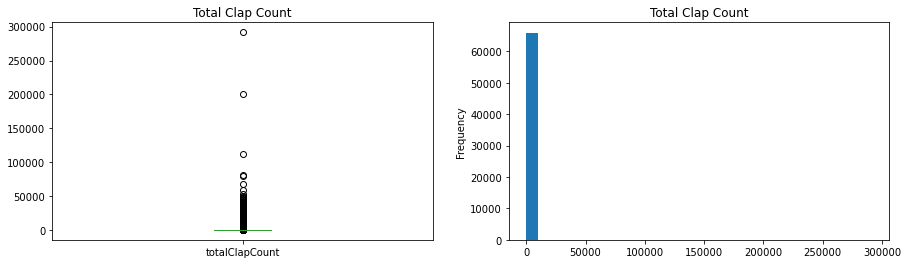

In [23]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Total Clap Count")
train.totalClapCount.plot.box();
plt.subplot(1, 2, 2)
plt.title("Total Clap Count")
train.totalClapCount.plot.hist(bins=30);

We notice that most of the articles have very low clap counts while there exist a few articles with vastly higher ones. We refrain from truncating the target variable since these articles are legitimate and achieved the high clap counts for a reason. If this holds true, there should be some kind of relatioship with a feature like "Responses":

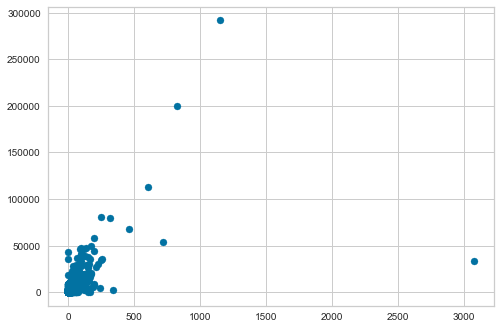

In [164]:
plt.scatter(train.Responses, train.totalClapCount);

Indeed, this is the case. However, we notice another singular anomality in this scatter plot. The one article that got the most responses actually deviates from the joint distribution by having way too low of a clap count.

In [129]:
train.index[np.where(train.Responses > 3000)]

Int64Index([49853], dtype='int64')

In [130]:
train.url[49853]

'https://medium.com/s/story/the-snips-air-token-sale-4511320d68d0'

It seems to be about some kind of ICO, and most of the comments are simply praising the project.

We can see how much leverage this single point has on a linear regression:

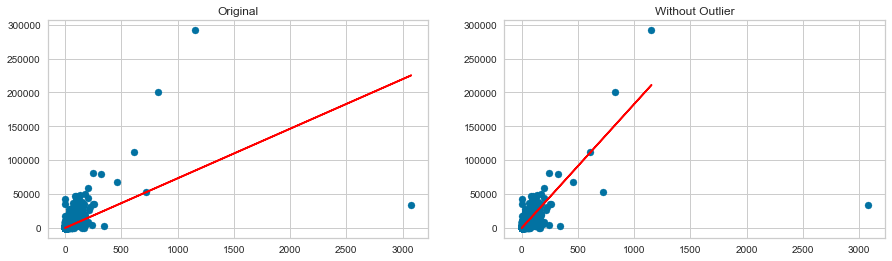

In [167]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
m, b = np.polyfit(train.Responses, train.totalClapCount, 1)
plt.scatter(train.Responses, train.totalClapCount)
plt.plot(train.Responses, m*train.Responses + b, color="red");
plt.subplot(1, 2, 2)
plt.title("Without Outlier")
m, b = np.polyfit(train.drop(49853).Responses, train.drop(49853).totalClapCount, 1)
plt.scatter(train.Responses, train.totalClapCount)
plt.plot(train.drop(49853).Responses, m*train.drop(49853).Responses + b, color="red");

For this reason, we decide to truncate the responses on this article to fit our regression line:

In [171]:
new_value = (train.totalClapCount[49853] - b) / m
new_value

185.07930865556216

In [183]:
train.loc[49853, "Responses"] = round(new_value)

We still need to take this uneven distribution into consideration for training, whether through using a robust loss function or some kind of transformation. Especially when training an NLP model, this is important, since there is no Response feature to guide it.

---
### 4.2 Reading Ease
Moving on, we introduce a measure called Flesch-Reading-Ease (FRE), which is a numerical value for the readability of a text. The higher the value, the better, with well-readable texts averaging an FRE of around 60-70. The formula is dependent on the language analyzed. Below is the formula for the English language:

$FRE = 206.835 - 1.015 \cdot ASL - 84.6 \cdot ASW$

$ASL \text{ (Average Sentence Length)} := \frac{Word Count}{Sentence Count}$

$ASW \text{ (Average Syllables per Word)} := \frac{Syllable Count}{Word Count}$

In [438]:
def fre(text):
    wordcount = len(re.findall(r"\w+", text))
    if wordcount == 0:
        return np.nan
    sentencecount = len(sent_tokenize(text))
    syllablecount = textstat.syllable_count(text)
    asl = wordcount / sentencecount
    asw = syllablecount / wordcount
    return 206.835 - 1.015 * asl - 84.6 * asw

As mentioned earlier, the half clean version of the texts comes in handy for counting sentences and words.

In [439]:
train["readingEase"] = train.text_half_clean.apply(fre)
test["readingEase"] = test.text_half_clean.apply(fre)

Normally, this score ranges from 0-100, and - while values below 0 and above 100 are possible - they are very rare. If we look at the distribution in our case, we do find the most articles to be in the expected range. However, there are some exceedingly negative scores which almost definitely signal that something is wrong with these texts.

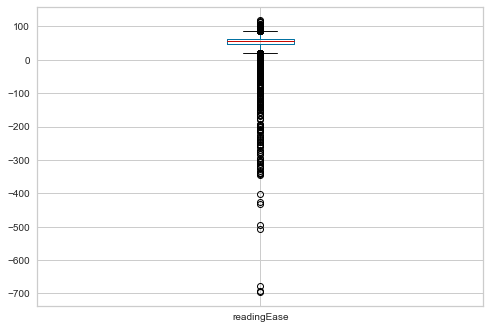

In [440]:
train.readingEase.plot.box();

First, we handle some articles that got a missing value because their word count was 0:

In [919]:
train.loc[train.readingEase.isnull(), ["title", "text", "totalClapCount", "wordCount"]]

,title,text,totalClapCount,wordCount
48738,www.destiney-ai.com :),www.destiney-ai.com :)\n\n,0,3
77229,Humanity will suffer under AI if we don´t act ...,\n,30,0
106849,https://icoratingblog.wordpress.com/2017/12/07...,https://icoratingblog.wordpress.com/2017/12/07...,0,3
134191,https://icoratingblog.wordpress.com/2017/12/05...,https://icoratingblog.wordpress.com/2017/12/05...,0,3
139814,https://blog.juecell.in/2018/08/artificial-int...,https://blog.juecell.in/2018/08/artificial-int...,0,4
166624,https://knowledgebuilderblog.wordpress.com/,https://knowledgebuilderblog.wordpress.com/\n,0,1
223367,https://icoratingblog.wordpress.com/2017/12/07...,https://icoratingblog.wordpress.com/2017/12/07...,0,3


We notice that these articles only consist of URLs or are empty altogether. We therefore opt to drop them from the set.

In [928]:
train.drop(train.index[train.readingEase.isnull()], inplace=True)

We further observe 471 articles with negative reading ease. Looking at the boxplot, a couple of articles with reading ease below -400 stand out especially.

In [972]:
len(train.loc[train.readingEase.values < -400, :])

15

In [975]:
for x in train.loc[train.readingEase.values < -400, "text_half_clean"]:
    print(x)

These seem to be weirdly formatted or spam articles. We also drop these from the set.

In [970]:
train.drop(train.index[train.readingEase.values < -400], inplace=True)

We do not want to alter the data set too much, however, since such spam articles are likely to achieve a low clap count. Therefore, we rely on the predictive power of this feature for the remaining articles with negative reading ease.

As we can see, almost all the articles with clap count above 0 lie in the usual FRE range:

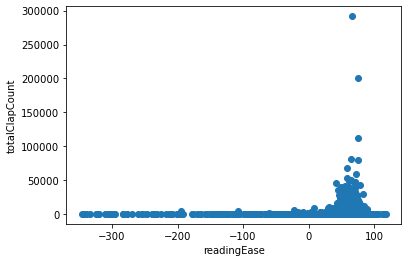

In [981]:
plt.figure()
plt.ylabel("totalClapCount")
plt.xlabel("readingEase")
plt.scatter(train.readingEase, train.totalClapCount);

The distribution in the test set looks healthy.

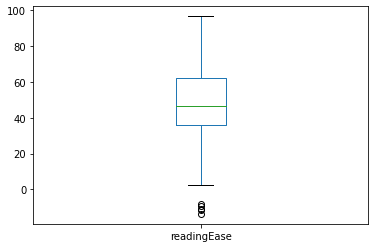

In [1064]:
test.readingEase.plot.box();

---
### 4.3 Date features
We will now analyze the date features we created earlier.

The average clap count seems to fluctuate between the weekdays. Especially on the weekends, one can expect relatively higher claps on their articles. This feature seems to be useful for prediction.

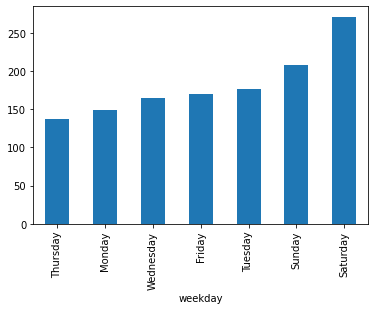

In [1068]:
train.groupby("weekday")["totalClapCount"].agg("mean").sort_values().plot.bar();

Comparing the weekday distribution of train and test set, we make the observation that much less articles from the test set were posted on a weekend. This is a contrast we would miss, would we not use this feature.

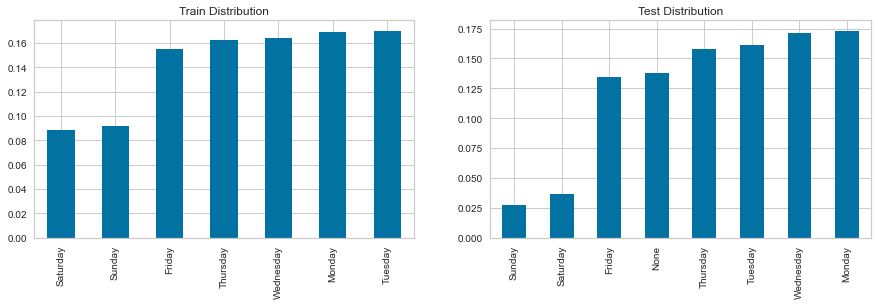

In [507]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Train Distribution")
pd.Series(train.weekday.value_counts()/len(train)).sort_values().plot.bar();
plt.subplot(1, 2, 2)
plt.title("Test Distribution")
pd.Series(test.weekday.value_counts()/len(test)).sort_values().plot.bar();

We conduct the same analysis for the month attribute and make a similar observation:

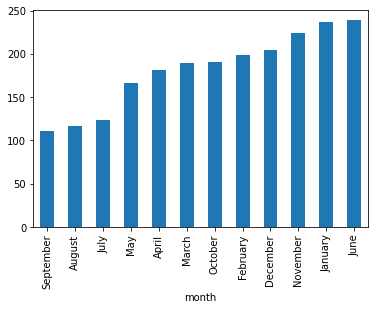

In [1017]:
train.groupby("month")["totalClapCount"].agg("mean").sort_values().plot.bar();

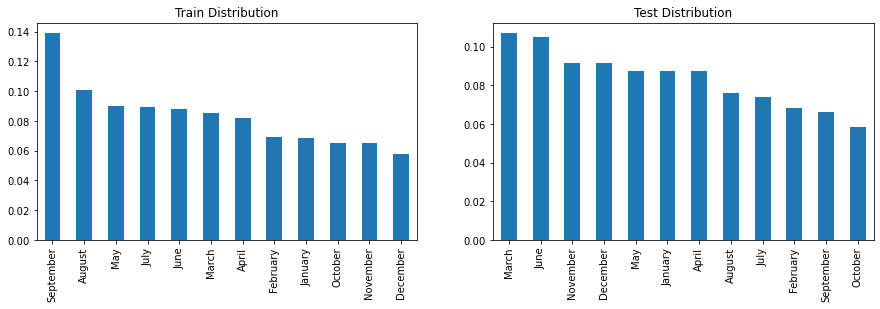

In [1014]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Train Distribution")
pd.Series(train.month.value_counts()/len(train)).plot.bar();
plt.subplot(1, 2, 2)
plt.title("Test Distribution")
pd.Series(test.month.value_counts()/len(test)).plot.bar();

The year category behaves a little differently, since there are many more year categories present in the test data. Since a model would be unable to properly learn how a year earlier than 2017 affects the clap count, it is questionable whether this feature is a strong predictor.

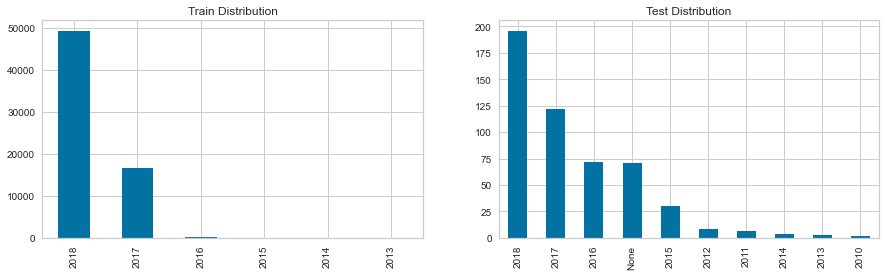

In [509]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Train Distribution")
pd.Series(train.year.value_counts()).plot.bar();
plt.subplot(1, 2, 2)
plt.title("Test Distribution")
pd.Series(test.year.value_counts()).plot.bar();

---
### 4.4 Title Length
We introduce another feature with the word count of the article's titles. Interestingly, most of the articles in both data sets have between 4 and 6 words, but the most successful title lenghts are 6-9 words long. The high average value for length 13 is most likely caused by a combination of few articles having such a long title, and one article with a very high clap count being one of them.

In [1038]:
train["titleLength"] = train.title_clean.apply(lambda x: len(str(x).split()))
test["titleLength"] = test.title_clean.apply(lambda x: len(str(x).split()))

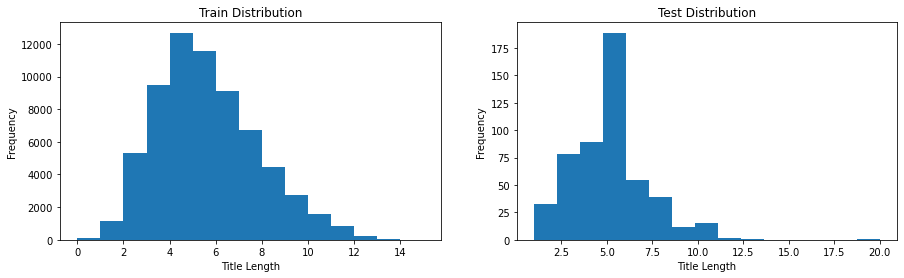

In [1063]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Train Distribution")
plt.xlabel("Title Length")
train.titleLength.plot.hist(bins=15);
plt.subplot(1, 2, 2)
plt.title("Test Distribution")
plt.xlabel("Title Length")
test.titleLength.plot.hist(bins=15);

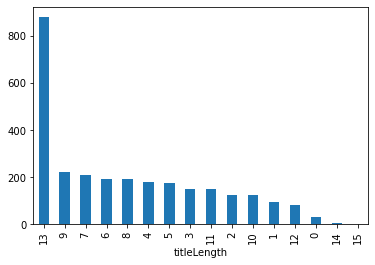

In [1046]:
train.groupby("titleLength")["totalClapCount"].agg("mean").sort_values(ascending=False).plot.bar();

---
### 4.5 Author
In this section, we try determine whether the author feature can be of value for us. This feature is not very clean, so we need to pull some of the authors from the publication details:

In [1079]:
test.author

index
0      Daniel Jeffries
1        Noam Levenson
2      Daniel Jeffries
5       Haseeb Qureshi
7         William Belk
            ...       
598        Jun 9, 2016
599       Jun 10, 2016
600             Mar-19
601       Mar 18, 2016
602       Jan 11, 2018
Name: author, Length: 514, dtype: object

In [1080]:
authors_from_details = []
for t in test.PublicationDetails:
    author = re.findall(r".+?(?=\sin\s)", t)
    if not author:
        author = re.findall(r".+?(?=;)", t)
    if not author:
        author = re.findall(r".+?(?=Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)", t)
    if not author:
        authors_from_details.append("N/A")
    else:
        authors_from_details.append(author.pop())

In [1081]:
test.author = authors_from_details

In [1083]:
test.author

index
0      Daniel Jeffries
1        Noam Levenson
2      Daniel Jeffries
5       Haseeb Qureshi
7         William Belk
            ...       
598         Tim Romero
599       Product Hunt
600       Joe Procopio
601           Winerist
602       Aytekin Tank
Name: author, Length: 514, dtype: object

The majority of articles in the test set are written by the Netflix Technology Blog and TE-FOOD.

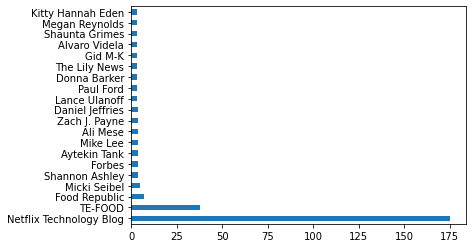

In [1082]:
test.author.value_counts()[:20].plot.barh();

In the train set, however, this looks entirely different. In fact, if we calculate how many rows of the train set contain authors present in the test set, we find a meager 244.

We therefore decide against using the author as a feature for modelling.

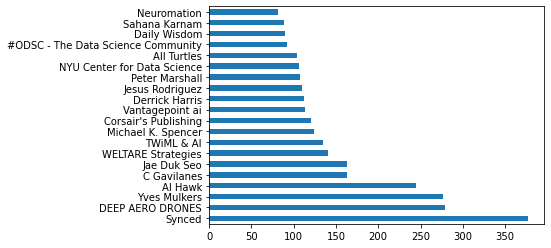

In [1099]:
train.author.value_counts()[:20].plot.barh();

In [1101]:
rows_covered = 0
for a in test.author.unique():
    where = train.index[np.where(train.author.values == a)[0]]
    rows_covered += len(where)
    
print(f"Out of all the rows in the train set, only {rows_covered} contain an author from the test set.")

Out of all the rows in the train set, only 244 contain an author from the test set.


---
### 4.6 Most Used Words
Lastly, we want to analyze the actual text features for keywords that predict a higher clap count by themselves.

We first look at the most used words in the **top 5% articles** of the train data with respect to clap count.

In [441]:
topfiveperc_value = np.percentile(train.totalClapCount,95,interpolation="higher")
topfiveperc_ix = train.index[np.where(train.totalClapCount>topfiveperc_value)]

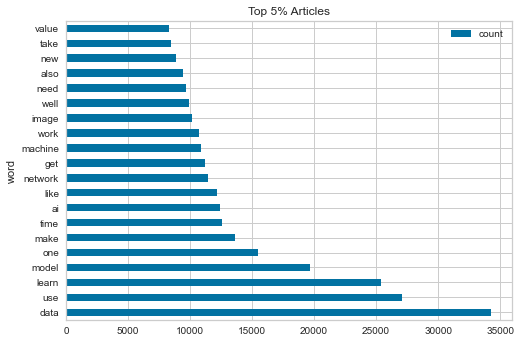

In [442]:
split_it = train.text_clean[topfiveperc_ix].apply(lambda x: Counter(x.split()).most_common())

wordcounts = {}
for ele in split_it:
    for word, count in ele:
        if word in wordcounts.keys():
            wordcounts[word] += count
        else:
            wordcounts[word] = count
            
counts_df = pd.DataFrame({"word": list(wordcounts.keys()), "count": list(wordcounts.values())})
counts_df.sort_values(by="count",ascending=False)[:20].plot.barh(x="word", title="Top 5% Articles");

Now, we compare this with the word count distribution of the **total** data:

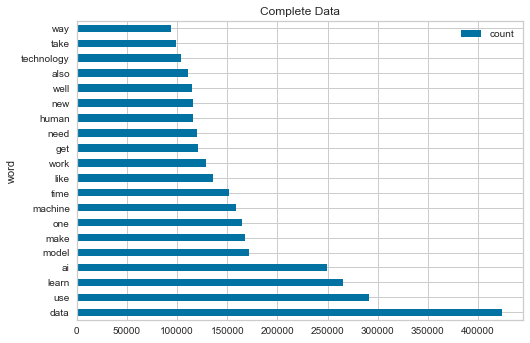

In [443]:
split_it = train.text_clean.apply(lambda x: Counter(x.split()).most_common())

wordcounts = {}
for ele in split_it:
    for word, count in ele:
        if word in wordcounts.keys():
            wordcounts[word] += count
        else:
            wordcounts[word] = count
            
counts_df = pd.DataFrame({"word": list(wordcounts.keys()), "count": list(wordcounts.values())})
counts_df.sort_values(by="count",ascending=False)[:20].plot.barh(x="word", title="Complete Data");

We compare this with the word usage of the **bottom 5% articles**:

In [444]:
bottomfiveperc_value = np.percentile(train.totalClapCount,5,interpolation="lower")
bottomfiveperc_ix = train.index[np.where(train.totalClapCount<=bottomfiveperc_value)]

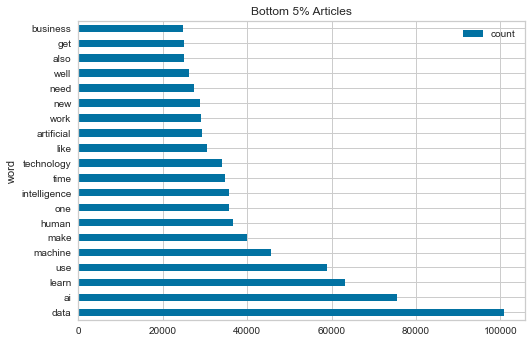

In [445]:
split_it = train.text_clean[bottomfiveperc_ix].apply(lambda x: Counter(x.split()).most_common())

wordcounts = {}
for ele in split_it:
    for word, count in ele:
        if word in wordcounts.keys():
            wordcounts[word] += count
        else:
            wordcounts[word] = count
            
counts_df = pd.DataFrame({"word": list(wordcounts.keys()), "count": list(wordcounts.values())})
counts_df.sort_values(by="count",ascending=False)[:20].plot.barh(x="word", title="Bottom 5% Articles");

The one major difference we can make out is the lowering relative popularity of the word "ai" the higher an article scores. We will rely on our LSTM to catch on to this connection.

---
## 5. Model Selection

### 5.1 Data Preparation

Before we proceed with benchmarking and modeling, we need to make sure that our text features are in appropriate format to be fed into NLP algorithms. Additionally, we need to load our pre-trained embeddings and make some changes to the text to be able to unlock their full potential.

For our embeddings, we decide to go with 100-dimensional wiki2vec embeddings from https://wikipedia2vec.github.io/wikipedia2vec/pretrained/

These have the advantage of containing ENTITY-entries, which solve the problem of ["big", "data"] versus ["Big Data"].

In [3]:
# Load wiki2vec embeddings:
start = time.time()
wiki2vec = KeyedVectors.load_word2vec_format('Data/enwiki_20180420_100d.txt')
end = time.time()
print(f"Loaded wiki2vec embeddings in {end - start} seconds.")

Loaded wiki2vec embeddings in 522.3371086120605 seconds.


Since the articles mostly cover Machine Learning, AI, etc., we transform some of the most used word constructs (see section 3.6) into entity tokens compatible with our embeddings. This list is of course not exhaustive, but considering that the word vector for "ai" returns japenese words (presumably because "ai" means "love" in japanese), and how often such words are used in our text features, we believe that this will already boost performance considerably.

In [9]:
wiki2vec.most_similar("ai")

[('chuseyo', 0.7419208288192749),
 ('donoshiro', 0.7339354157447815),
 ('shitteita', 0.723736047744751),
 ('chắc', 0.7184919714927673),
 ('champandard', 0.7161723971366882),
 ('yobundaze', 0.7159942388534546),
 ('tegotae', 0.7130879759788513),
 ('oboete', 0.7121416330337524),
 ('motenashite', 0.70948326587677),
 ('yobunda', 0.707751452922821)]

In [10]:
wiki2vec.most_similar("ENTITY/Artificial_intelligence")

[('ENTITY/Artificial_general_intelligence', 0.7941759824752808),
 ('ENTITY/Outline_of_artificial_intelligence', 0.7715780735015869),
 ('ENTITY/Artificial_intelligence_in_video_games', 0.7647756338119507),
 ('ENTITY/Weak_AI', 0.7507199645042419),
 ('ENTITY/Machine_learning', 0.7487928867340088),
 ('ENTITY/Glossary_of_artificial_intelligence', 0.7407300472259521),
 ('ENTITY/Cognitive_robotics', 0.7399426698684692),
 ('ENTITY/Hybrid_intelligent_system', 0.7390654683113098),
 ('ENTITY/Turing_test', 0.7375492453575134),
 ('ENTITY/Multi-agent_system', 0.7318432331085205)]

In [69]:
def transform_entities(text):
    text = re.sub(r"\bdata science\b", "ENTITY/Data_science", text)
    text = re.sub(r"\bdeep learn\b", "ENTITY/Deep_learning", text)
    text = re.sub(r"\bbig data\b", "ENTITY/Big_data", text)
    text = re.sub(r"\bgoogle\b", "ENTITY/Google", text)
    text = re.sub(r"\bdata analysis\b", "ENTITY/Data_analysis", text)
    text = re.sub(r"\bartificial intelligence\b", "ENTITY/Artificial_intelligence", text)
    text = re.sub(r"\bai\b", "ENTITY/Artificial_intelligence", text)
    text = re.sub(r"\bmachine learning\b", "ENTITY/Machine_learning", text)
    text = re.sub(r"\bmachine learn\b", "ENTITY/Machine_learning", text)
    text = re.sub(r"\bml\b", "ENTITY/Machine_learning", text)
    text = re.sub(r"\btf\b", "ENTITY/TensorFlow", text)
    text = re.sub(r"\btensorflow\b", "ENTITY/TensorFlow", text)
    text = re.sub(r"\bvm\b", "ENTITY/Virtual_machine", text)
    text = re.sub(r"\bar\b", "ENTITY/Augmented_reality", text)
    text = re.sub(r"\bfb\b", "ENTITY/Facebook", text)
    text = re.sub(r"\biot\b", "ENTITY/Internet_of_things", text)
    text = re.sub(r"\bblockchain\b", "ENTITY/Blockchain", text)
    # This has to be last:
    text = re.sub(r"\bdata\b", "ENTITY/Data", text)
    return text

In [1127]:
train["title_clean"] = train.title_clean.apply(transform_entities)
train["text_clean"] = train.text_clean.apply(transform_entities)

In [1128]:
test["title_clean"] = test.title_clean.apply(transform_entities)
test["text_clean"] = test.text_clean.apply(transform_entities)

---
After this is done, we prepare our train and test sets which we will be using to measure the performance of the different NLP models we employ.

In [447]:
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(train[['title_clean', 'text_clean', "imageCount", "readingTime", "titleLength", "Responses", "month", "weekday", "readingEase"]], train['totalClapCount'], test_size=0.20, random_state=111)
X_train_nlp = pd.get_dummies(X_train_nlp, columns=["month","weekday"])
X_test_nlp = pd.get_dummies(X_test_nlp, columns=["month","weekday"])

Tokenized objects and embedding matrices are initialized separately for title and text. For the text, we truncate the articles at 400 words since excessively long sequences can make an LSTM run into trouble. For the titles, we decide on a maximum length of 20 words, which lets us use most of the titles without any truncation.

It is important to exclude the filters for "/" and "_" from the tokenizer, and to not transform the sequences to lower case, since this would destroy the ENTITY-constructs we just built.

The texts are all alphanumeric and in lower case anyway because of our cleaning loop.

In [448]:
tokenizer_text = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_text.fit_on_texts(X_train_nlp.text_clean)
NUM_WORDS_TEXT = len(tokenizer_text.word_index) + 1

X_tr_int_text = tokenizer_text.texts_to_sequences(X_train_nlp.text_clean)
max_article_length = max([len(article) for article in X_tr_int_text])
print('The longest article of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TEXT_LENGTH = 400
X_tr_int_pad_text = pad_sequences(X_tr_int_text, MAX_TEXT_LENGTH)

# Encode and pad the test data
X_ts_int_text = tokenizer_text.texts_to_sequences(X_test_nlp.text_clean)
X_ts_int_pad_text = pad_sequences(X_ts_int_text, MAX_TEXT_LENGTH)

wiki_weights_text, _ = get_embedding_matrix(tokenizer_text, wiki2vec, NUM_WORDS_TEXT)

The longest article of the training set has 12810 words.
Created embedding matrix of shape (184259, 100)
Encountered 68078 out-of-vocabulary words.


In [449]:
tokenizer_title = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_title.fit_on_texts(X_train_nlp.title_clean)
NUM_WORDS_TITLE = len(tokenizer_title.word_index) + 1

X_tr_int_title = tokenizer_title.texts_to_sequences(X_train_nlp.title_clean)
max_article_length = max([len(article) for article in X_tr_int_title])
print('The longest title of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TITLE_LENGTH = 20
X_tr_int_pad_title = pad_sequences(X_tr_int_title, MAX_TITLE_LENGTH)

# Encode and pad the test data
X_ts_int_title = tokenizer_title.texts_to_sequences(X_test_nlp.title_clean)
X_ts_int_pad_title = pad_sequences(X_ts_int_title, MAX_TITLE_LENGTH)

wiki_weights_title, _ = get_embedding_matrix(tokenizer_title, wiki2vec, NUM_WORDS_TITLE)

The longest title of the training set has 15 words.
Created embedding matrix of shape (19830, 100)
Encountered 3070 out-of-vocabulary words.


For both the texts and the titles, we find a fair share of out-of-vocabulary words. While the most frequent words are likely to be included, this problem can be mitigated a little by making our pre-trained embeddings trainable.


### 5.2 Benchmark Models

To be able to judge the performance of our final model, we introduce some more naive models in order to have a couple of benchmark performance thresholds.

1. A linear regression on non-text features
2. A Random Forest on non-text features
3. An xgb model on non-text features
4. A basic GRU with self-trained embeddings on text features

#### 5.2.1 Linear Regression

In [519]:

X_train, X_test, y_train, y_test = train_test_split(train[["imageCount", "readingTime", "titleLength", "Responses", "month", "weekday", "readingEase"]], train['totalClapCount'], test_size=0.20, random_state=111)
X_train = pd.get_dummies(X_train, columns=["month","weekday"])
X_test = pd.get_dummies(X_test, columns=["month","weekday"])

regression = LinearRegression(normalize=True)
regression.fit(X_train, y_train)

prediction = pd.DataFrame({"Prediction": regression.predict(X_test), "Actual": y_test})

print(f"R2: {regression.score(X_test, y_test)}")
print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction)}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")


R2: 0.8109691126338229
MSE: 772127.6433689402
MAE: 139.30276260404844


This is already a very nice result. We perform 10-fold cross-validation to make sure it is not a lucky sample:

In [520]:
X = train[["imageCount", "readingTime", "titleLength", "Responses", "month", "weekday", "readingEase"]].copy()
X = pd.get_dummies(X, columns=["month","weekday"])
y = train['totalClapCount'].copy()

kf = KFold(n_splits=10, shuffle=True, random_state=111)
xgb_predictions = pd.DataFrame(columns=["pred", "actual"], index=X.index)
xgb_predictions["actual"] = y

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[X.index[train_index], :], X.loc[X.index[test_index], :]
    y_train, y_test = y[y.index[train_index]], y[y.index[test_index]]
    
    regression = LinearRegression(normalize=True)
    regression.fit(X_train, y_train)

    prediction = pd.DataFrame({"Prediction": regression.predict(X_test), "Actual": y_test})
    
print(f"MSE: {mean_squared_error(prediction.Prediction, prediction.Actual)}")
print(f"MAE: {mean_absolute_error(prediction.Prediction, prediction.Actual)}")  

MSE: 1119294.8724935956
MAE: 147.96296778038445


The performance got worse but is still good.

#### 5.2.2 Random Forest

In [521]:

X_train, X_test, y_train, y_test = train_test_split(train[["imageCount", "readingTime", "titleLength", "Responses", "month", "weekday", "readingEase"]], train['totalClapCount'], test_size=0.20, random_state=111)
X_train = pd.get_dummies(X_train, columns=["month","weekday"])
X_test = pd.get_dummies(X_test, columns=["month","weekday"])

rf = RandomForestRegressor(n_estimators=1000, max_depth = None, max_samples = 0.1, random_state=111, verbose=0, n_jobs=10)
rf.fit(X_train, y_train)

prediction = pd.DataFrame({"Prediction": rf.predict(X_test), "Actual": y_test})

print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction)}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")

MSE: 1983383.3408722386
MAE: 148.7260903140371


The Random Forest on the other hand performs worse on this split than the linear regression concerning both MAE and MSE. The high MSE is likely from the Random Forest's inability to predict very high values in this particular case:

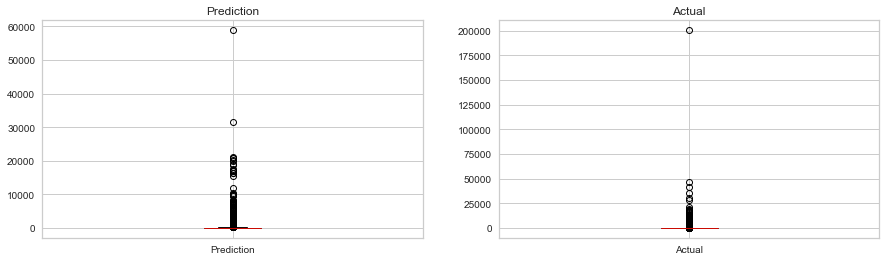

In [275]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Prediction")
prediction.Prediction.plot.box();
plt.subplot(1, 2, 2)
plt.title("Actual")
prediction.Actual.plot.box();

#### 5.2.3 XGBoost

In [301]:
X_train, X_test, y_train, y_test = train_test_split(train[["imageCount", "readingTime", "titleLength", "Responses", "month", "weekday", "readingEase"]], train['totalClapCount'], test_size=0.20, random_state=111)
X_train = pd.get_dummies(X_train, columns=["month","weekday"])
X_test = pd.get_dummies(X_test, columns=["month","weekday"])

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,
                max_depth=2, alpha=20, n_estimators = 600)
xg_reg.fit(X_train,y_train)

prediction = pd.DataFrame({"Prediction": xg_reg.predict(X_test), "Actual": y_test})

print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction)}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")

MSE: 692595.4650900621
MAE: 138.31060056936278


The XGBoost model's performance on this split is even better than the linear regression. We also perform 10-fold cross-validation here to test whether this result is legitimate:

In [302]:
X = train[["imageCount", "readingTime", "titleLength", "Responses", "month", "weekday", "readingEase"]].copy()
X = pd.get_dummies(X, columns=["month","weekday"])
y = train['totalClapCount'].copy()

kf = KFold(n_splits=10, shuffle=True, random_state=111)
xgb_predictions = pd.DataFrame(columns=["pred", "actual"], index=X.index)
xgb_predictions["actual"] = y

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[X.index[train_index], :], X.loc[X.index[test_index], :]
    y_train, y_test = y[y.index[train_index]], y[y.index[test_index]]
    
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=1, learning_rate=0.1,
                max_depth=2, alpha=20, n_estimators = 600)
    xg_reg.fit(X_train,y_train)

    xgb_predictions.loc[X.index[test_index], "pred"] = xg_reg.predict(X_test)
    
print(f"MSE: {mean_squared_error(xgb_predictions.pred, xgb_predictions.actual)}")
print(f"MAE: {mean_absolute_error(xgb_predictions.pred, xgb_predictions.actual)}")  


MSE: 1436947.1759841486
MAE: 144.8958819542823


The performance decreased by quite a lot, but the MAE is still the best. MSE-wise, it seems like the linear regression is the winning benchmark. This gives us a baseline for what to expect from non-text features.

The comparably low MSE of the linear regression is quite interesting. Since there exists an almost linear connection between clap count and responses, the linear regression is likely to make a good prediction on articles with high clap counts. However, this comes at the expense of making many small errors at the lower clap count level, exemplified by the relatively high MAE.

This leads us to an important question: Which loss function should actually be used? MSE is not very robust to outliers, which is why non-linear models will struggle when encountering these examples. In order to correctly predict high clap scores, it is likely that the prediction of articles with lower clap counts (which the train set consists mostly of) is hurt in the process. Furthermore, the occurence of such outliers is so rare that we cannot justify the high impact they have on our loss function.\
We therefore make the decision to not use MSE loss for the following models.

#### 5.2.4 Basic GRU

To get a feeling of the text features' predictive power, we also employ a basic NLP model with self-training embeddings.\
The Keras Functional API allows us to effectively train a text and a title model at the same time.

The number of hidden units in the GRUs is chosen to be 100, and the final activation functions are set to ReLU, since clap counts are never negative.

As explained, we refrain from using mean squared error loss, since it would make training performance difficult to judge.\
Instead, we could use the mean absolute error, but this loss can have difficulties finding a minimum because of its shape, especially at the high batch size of 256.

We therefore decide for log-cosh loss, which behaves very similarly to MAE, but does not suffer as much from the aforementioned negative property.

In [ ]:
input_text = Input(shape=(400, ))
input_title = Input(shape=(20, ))

# Text
text_embeddings = Embedding(input_dim=NUM_WORDS_TEXT, output_dim=100, input_length=400)(input_text)
GRU_text = GRU(100)(text_embeddings)
dense_text = Dense(1, activation="relu")(GRU_text)

# Title
title_embeddings = Embedding(input_dim=NUM_WORDS_TITLE, output_dim=100, input_length=20)(input_title)
GRU_title = GRU(100)(title_embeddings)
dense_title = Dense(1, activation="relu")(GRU_title)

# Concatenate
output_layer = concatenate([dense_text, dense_title])

model = Model(inputs=[input_text, input_title], outputs=output_layer)
model.compile(loss=losses.LogCosh(), optimizer="adam", metrics=["mae", "mse"])

print(model.summary())
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title], y_train_nlp, epochs=10, verbose=1, batch_size=256, 
          validation_split=0.2, callbacks=callbacks)

In [25]:
preds = pd.DataFrame(model.predict([X_ts_int_pad_text, X_ts_int_pad_title]), columns=["text_pred", "title_pred"], index=y_test_nlp.index)
preds["actual"] = y_test_nlp

In [26]:
print(f"Text MSE: {mean_squared_error(preds.text_pred, preds.actual)}")
print(f"Text MAE: {mean_absolute_error(preds.text_pred, preds.actual)}\n") 
print(f"Title MSE: {mean_squared_error(preds.title_pred, preds.actual)}")
print(f"Title MAE: {mean_absolute_error(preds.title_pred, preds.actual)}\n")

Text MSE: 4108188.4872280927
Text MAE: 168.19954001656407

Title MSE: 4111332.1781807323
Title MAE: 169.37107981226526



It appears as if the text features don't have nearly as much predictive power as the non-text ones, which shapes our expectation for the NLP model selection. Furthermore, the model already starts overfitting at the second epoch. If this trend carries over to our final model, we should be prepared for using regularization techniques.

---
### 5.3 RNN Architecture

Since there are so many possibilities for an NLP model, we limit ourselves to trying 3 different model configurations on the text features. For all of them, we decide on some kind of LSTM architecture with pre-trained wiki2vec embeddings.

1. LSTM
2. Bidirectional LSTM
3. Deep LSTM

For all of these models, different hyperparameter configurations were tested. The number of hidden units inside the LSTM units does not seem to make a big difference, so they are left at 100, same as with the benchmark GRU.

#### 5.3.1 LSTM

We start with a simple LSTM and fine-tuneable pre-trained embeddings to compare performances.

In [ ]:
input_text = Input(shape=(400, ))
input_title = Input(shape=(20, ))

# Text
text_embeddings = Embedding(NUM_WORDS_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_text),
                     input_length=400, trainable=True)(input_text)
LSTM_text = LSTM(100, return_sequences=False)(text_embeddings)
dense_text = Dense(1, activation="relu")(LSTM_text)

# Title
title_embeddings = Embedding(NUM_WORDS_TITLE, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_title),
                     input_length=20, trainable=True)(input_title)
LSTM_title = LSTM(100, return_sequences=False)(title_embeddings)
dense_title = Dense(1, activation="relu")(LSTM_title)

# Concatenate
output_layer = concatenate([dense_text, dense_title])

model = Model(inputs=[input_text, input_title], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title], y_train_nlp, epochs=15, verbose=1, batch_size=256, 
          validation_split=0.2, callbacks=callbacks)

In [105]:
preds = pd.DataFrame(model.predict([X_ts_int_pad_text, X_ts_int_pad_title]), columns=["text_pred", "title_pred"], index=y_test_nlp.index)
preds["actual"] = y_test_nlp

In [106]:
print(f"Text MSE: {mean_squared_error(preds.text_pred, preds.actual)}")
print(f"Text MAE: {mean_absolute_error(preds.text_pred, preds.actual)}\n") 
print(f"Title MSE: {mean_squared_error(preds.title_pred, preds.actual)}")
print(f"Title MAE: {mean_absolute_error(preds.title_pred, preds.actual)}\n")

Text MSE: 4093792.4950327245
Text MAE: 163.79626421171338

Title MSE: 4099533.340538796
Title MAE: 169.8877005444595



Using LSTMs instead of GRUs and fine-tuneable pre-trained embeddings does already produce above-benchmark performance. Especially notable is that this model starts to overfit much later than our benchmark, even though we did not use any regularization. However, from the results so far, it is apparent that the text features either do not hold much predictive power, or they cannot be harnessed well by our modeling approach.

#### 5.3.2 Bidirectional LSTM

Since we are dealing with predefined sequences (unlike stocks for example), we can consider using a bidirectional LSTM architecture to get a more accurate prediction.

In [ ]:
input_text = Input(shape=(400, ))
input_title = Input(shape=(20, ))

# Text
text_embeddings = Embedding(NUM_WORDS_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_text),
                     input_length=400, trainable=True)(input_text)
LSTM_text = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(text_embeddings)
dense_text = Dense(1, activation="relu")(LSTM_text)

# Title
title_embeddings = Embedding(NUM_WORDS_TITLE, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_title),
                     input_length=20, trainable=True)(input_title)
LSTM_title = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(title_embeddings)
dense_title = Dense(1, activation="relu")(LSTM_title)

# Concatenate
output_layer = concatenate([dense_text, dense_title])

model = Model(inputs=[input_text, input_title], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title], y_train_nlp, epochs=10, verbose=1, batch_size=256, 
          validation_split=0.2, callbacks=callbacks)

In [39]:
preds = pd.DataFrame(model.predict([X_ts_int_pad_text, X_ts_int_pad_title]), columns=["text_pred", "title_pred"], index=y_test_nlp.index)
preds["actual"] = y_test_nlp

In [40]:
print(f"Text MSE: {mean_squared_error(preds.text_pred, preds.actual)}")
print(f"Text MAE: {mean_absolute_error(preds.text_pred, preds.actual)}\n") 
print(f"Title MSE: {mean_squared_error(preds.title_pred, preds.actual)}")
print(f"Title MAE: {mean_absolute_error(preds.title_pred, preds.actual)}\n")

Text MSE: 4102799.3771413146
Text MAE: 165.08932957284455

Title MSE: 4105366.3325889613
Title MAE: 168.4695250574078



To our surprise, the bidirectional LSTM actually performs slightly worse than the unidirectional one, all the while taking considerably longer to train.

#### 5.3.3 Deep LSTM

Feeding the sequential LSTM output into another LSTM can improve performance in the same way as adding additional hidden layers to a vanilla Neural Network. We also expect this approch to take much longer to train, but it might be worth it if the performance turns out to be vastly superior.

In [42]:
input_text = Input(shape=(400, ))
input_title = Input(shape=(20, ))

# Text
text_embeddings = Embedding(NUM_WORDS_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_text),
                     input_length=400, trainable=True)(input_text)
LSTM_text_1 = LSTM(100, return_sequences=True)(text_embeddings)
LSTM_text_2 = LSTM(50, return_sequences=False)(LSTM_text_1)
dense_text = Dense(1, activation="relu")(LSTM_text_2)

# Title
title_embeddings = Embedding(NUM_WORDS_TITLE, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_title),
                     input_length=20, trainable=True)(input_title)
LSTM_title_1 = LSTM(100, return_sequences=True)(title_embeddings)
LSTM_title_2 = LSTM(50, return_sequences=False)(LSTM_title_1)
dense_title = Dense(1, activation="relu")(LSTM_title_2)

# Concatenate
output_layer = concatenate([dense_text, dense_title])

model = Model(inputs=[input_text, input_title], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title], y_train_nlp, epochs=10, verbose=1, batch_size=256, 
          validation_split=0.2, callbacks=callbacks)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 400)          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 400, 100)     18425900    input_21[0][0]                   
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 20, 100)      1983000     input_22[0][0]                   
___________________________________________________________________________________________

In [43]:
preds = pd.DataFrame(model.predict([X_ts_int_pad_text, X_ts_int_pad_title]), columns=["text_pred", "title_pred"], index=y_test_nlp.index)
preds["actual"] = y_test_nlp

In [44]:
print(f"Text MSE: {mean_squared_error(preds.text_pred, preds.actual)}")
print(f"Text MAE: {mean_absolute_error(preds.text_pred, preds.actual)}\n") 
print(f"Title MSE: {mean_squared_error(preds.title_pred, preds.actual)}")
print(f"Title MAE: {mean_absolute_error(preds.title_pred, preds.actual)}\n")

Text MSE: 4101094.8438519356
Text MAE: 166.03213977598577

Title MSE: 4102381.8221587776
Title MAE: 170.23820139897893



The validation loss in this case did start to improve overproportionally towards the end, but the small potential improvement over a single LSTM layer does not justify the long training time for our application.

---

Concluding this small experiment, we use a normal LSTM cell with 100 hidden units for training on our text data.

### 5.4 Full Model Architecture

We now need to make a decision on how to bring text and non-text predictions together. We could simply plug the non-text features into our existing model and train everything at once, but we suspect that the NLP and non-NLP models take different numbers of epochs until overfitting occurs.

In order to circumvent this issue, we first tried to employ a stacking architecture, where we separately trained NLP and non-NLP models, and plugged them into a second level model for a final prediction. To our surprise, this model performed very poorly and was promptly scrapped. To not unnecessarily bloat the notebook, we are not including it here. A point to note, however, is the long time such a model needs to be validated without bias. A cross-validation-like training procedure is necessary to acquire predictions for the whole training set without having to make predictions on training data. For this additional reason, we decided to not pursue the architecture further.

Instead, we went back to the single composite model. Our suspicion that the NLP models overfit much sooner than the non-NLP ones was true, but - as we soon found out - only due to the trainable embeddings. In fact, it serves almost like a "cheat sheet" of sorts and it could even be possible to attain almost perfect training predictions with long enough training this way.\
Therefore, our final decision is to employ a single model for text and non-text features, with untrainable embeddings.

An additional benefit this provides over a stacking architecture is that the backwards propagated gradients of the non-text data actually affect the training of our LSTMs and vice versa.

Our architecture follows the following order:
1. Train LSTMs on text and have them put out a single linear (not ReLU) value. The reason for this is that their outputs are now not final and truncating them would lose information
2. Concatenate these values with the non-text data
3. Train a deep neural network on the concatenated features

The architecture of the dense layers after the concatenation follows a bottleneck fashion, which is an often-used heuristic for building neural networks. The amounts of neurons in each layer was somewhat determined in a trial-and-error fashion where we noticed that a high amount of neurons boosted performance considerably.

In [451]:
input_text = Input(shape=(400, ))
input_title = Input(shape=(20, ))
input_nontext = Input(shape=(25, ))

# Text
text_embeddings = Embedding(NUM_WORDS_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_text),
                     input_length=400, trainable=False)(input_text)
LSTM_text = LSTM(100, return_sequences=False)(text_embeddings)
dense_text = Dense(1, activation="linear")(LSTM_text)

# Title
title_embeddings = Embedding(NUM_WORDS_TITLE, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_title),
                     input_length=20, trainable=False)(input_title)
LSTM_title = LSTM(100, return_sequences=False)(title_embeddings)
dense_title = Dense(1, activation="linear")(LSTM_title)

# Concatenate
concat = concatenate([dense_text, dense_title, input_nontext])
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

model = Model(inputs=[input_text, input_title, input_nontext], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title, X_train_nlp.drop(columns=["text_clean", "title_clean"])], 
                  y_train_nlp, epochs=30, verbose=1, batch_size=256, validation_split=0.2, callbacks=callbacks)

Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_117 (InputLayer)          (None, 400)          0                                            
__________________________________________________________________________________________________
input_118 (InputLayer)          (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_97 (Embedding)        (None, 400, 100)     18425900    input_117[0][0]                  
__________________________________________________________________________________________________
embedding_98 (Embedding)        (None, 20, 100)      1983000     input_118[0][0]                  
___________________________________________________________________________________________

In [458]:
model.evaluate([X_ts_int_pad_text, X_ts_int_pad_title, X_test_nlp.drop(columns=["text_clean", "title_clean"])], y_test_nlp)

13215/13215 [==============================] - 19s 1ms/step


[117.1130774034319, 117.6988296508789, 1435102.0]

The test MAE is considerably better than all of the benchmark models. The MSE is pretty high but this is expected and actually only due to a single article:

In [465]:
preds = pd.DataFrame(model.predict([X_ts_int_pad_text, X_ts_int_pad_title, X_test_nlp.drop(columns=["text_clean", "title_clean"])]), columns=["pred"], index=X_test_nlp.index)
preds["actual"] = y_test_nlp

In [493]:
mean_squared_error(preds[preds.actual < 200000].pred, preds[preds.actual < 200000].actual)

537943.7202919119

---
## 6. Application to Test Set

We now train our full model on the entire training data again. Therefore we first need to re-initialize our tokenizers so they take into account the whole set of words.

In [486]:
X = train[["text_clean", "title_clean", "imageCount", "readingTime", "titleLength", "Responses", "month", "weekday", "readingEase"]].copy()
X = pd.get_dummies(X, columns=["month", "weekday"])
y = train['totalClapCount'].copy()

tokenizer_text = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_text.fit_on_texts(X.text_clean)
NUM_WORDS_TEXT = len(tokenizer_text.word_index) + 1

X_tr_int_text = tokenizer_text.texts_to_sequences(X.text_clean)
max_article_length = max([len(article) for article in X_tr_int_text])
print('The longest article of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TEXT_LENGTH = 400
X_tr_int_pad_text = pad_sequences(X_tr_int_text, MAX_TEXT_LENGTH)

wiki_weights_text, _ = get_embedding_matrix(tokenizer_text, wiki2vec, NUM_WORDS_TEXT)

tokenizer_title = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_title.fit_on_texts(X.title_clean)
NUM_WORDS_TITLE = len(tokenizer_title.word_index) + 1

X_tr_int_title = tokenizer_title.texts_to_sequences(X.title_clean)
max_article_length = max([len(article) for article in X_tr_int_title])
print('The longest title of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TITLE_LENGTH = 20
X_tr_int_pad_title = pad_sequences(X_tr_int_title, MAX_TITLE_LENGTH)

wiki_weights_title, _ = get_embedding_matrix(tokenizer_title, wiki2vec, NUM_WORDS_TITLE)

The longest article of the training set has 12810 words.
Created embedding matrix of shape (209790, 100)
Encountered 81771 out-of-vocabulary words.
The longest title of the training set has 15 words.
Created embedding matrix of shape (22198, 100)
Encountered 3626 out-of-vocabulary words.


Now we train the model on this, with the optimal epoch value from section 5.4.

In [489]:
input_text = Input(shape=(400, ))
input_title = Input(shape=(20, ))
input_nontext = Input(shape=(25, ))

# Text
text_embeddings = Embedding(NUM_WORDS_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_text),
                     input_length=400, trainable=False)(input_text)
LSTM_text = LSTM(100, return_sequences=False)(text_embeddings)
dense_text = Dense(1, activation="linear")(LSTM_text)

# Title
title_embeddings = Embedding(NUM_WORDS_TITLE, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_title),
                     input_length=20, trainable=False)(input_title)
LSTM_title = LSTM(100, return_sequences=False)(title_embeddings)
dense_title = Dense(1, activation="linear")(LSTM_title)

# Concatenate
concat = concatenate([dense_text, dense_title, input_nontext])
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

model = Model(inputs=[input_text, input_title, input_nontext], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())

story = model.fit([X_tr_int_pad_text, X_tr_int_pad_title, X.drop(columns=["text_clean", "title_clean"])], 
                  y, epochs=8, verbose=1, batch_size=256)

Model: "model_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_147 (InputLayer)          (None, 400)          0                                            
__________________________________________________________________________________________________
input_148 (InputLayer)          (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_117 (Embedding)       (None, 400, 100)     20979000    input_147[0][0]                  
__________________________________________________________________________________________________
embedding_118 (Embedding)       (None, 20, 100)      2219800     input_148[0][0]                  
___________________________________________________________________________________________

To make predictions on the test set, we need to prepare it too with the tokenizers we just re-initialized:

In [490]:
test_int_text = tokenizer_text.texts_to_sequences(test.text_clean)
test_int_pad_text = pad_sequences(test_int_text, MAX_TEXT_LENGTH)

test_int_title = tokenizer_title.texts_to_sequences(test.title_clean)
test_int_pad_title = pad_sequences(test_int_title, MAX_TITLE_LENGTH)

test_X = test[["imageCount", "readingTime", "titleLength", "Responses", "month", "weekday", "readingEase"]].copy()
test_X = pd.get_dummies(test_X, columns=["month", "weekday"])

In [491]:
final_composite_predictions = pd.DataFrame(model.predict([test_int_pad_text, test_int_pad_title, test_X]), columns=["Claps"], index=test.index)
final_composite_predictions

,Claps
index,
0,73027.156250
1,20032.468750
2,18680.517578
5,10834.714844
7,800.700500
...,...
598,22004.570312
599,1480.981934
600,4411.982422


Finally, we clip predictions below 0 since clap counts below 0 do not make sense:

In [495]:
final_composite_predictions = np.clip(final_composite_predictions, a_min=0, a_max=None)

The last step is to create a csv for the submission:

In [497]:
final_composite_predictions.to_csv("submission.csv")

## 7. Conclusion

In this assignment, the focus lay on Natural Language Processing and the data set represented a good example of real world data. Unfortunately, we were either not quite able to harness the predictive power of the text features, or they did not have much. The other features outshone them by a fair amount. Either way, we still believe that NLP had a positive impact on our final result.

As future improvements, the data cleaning could be done even more thoroughly, since we are sure that there still exist anomalities in the text features. On the other hand, it would probably never be possible to fully clean this data set.\
Furthermore, a more complex model architecture would not be a bad idea, since there exist already way more advanced structures like transformer networks. However, one always has to take into account the balance between computational complexity and model performance. We believe that this task is a good example for an at-home application of NLP.

A lot of knowledge about Recurrent Neural Networks, Machine Learning in general, and also the relevant python libraries was gained in the scope of the task.